# Agent 3 - Tabular Sarsa(λ)

Agent 2 (MC Method) worked reasonably well. After around playing around 50,000 training games, it learned a policy that could be used to consistently beat the random agent and also beat the `negamax` agent over 50% of the time. Still, this agent's abilities are limited by the fact that it only updates the value of each state after entire episodes. We have learned that this approach is not always optimal, and so n-step TD methods (which update the reward for a state based on the next n-steps) are often better. 

n-step TD have two notable limitations themselves: they take alot of memory and have a delay in updating. TD(λ) methods, which give the overall return for a step as a weighted combination of various n-step TD returns, avoid these issues. In this section, I implement SARSA(λ), a control version of TD(λ) that learns action values instead of state values.

## Step 1: Load environment

In [84]:
#####
##### Step 1: Load Environment

!pip install kaggle-environments

###### Import necessary libraries (run this twice per instructions)
from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))

from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

# List of available default agents
print(list(env.agents))

##### Other libraries and functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # to keep track of the progress
from collections import defaultdict  # we will see why this is something useful for our case

['random', 'negamax']
['random', 'negamax']


In [86]:
#####
##### Define environment parameters, make environment
#####
rows = 4
columns = 5
in_a_row = 3
debug_mode = True


env = make("connectx", {"rows": rows, "columns": columns, "inarow": in_a_row}, steps=[], debug=debug_mode)

## Step 2: Bring in helper functions from code for Agent 2: MC Method 

For taking information about state from game, generating episodes, etc. For documentation on these functions see the Agent 2 notebook

In [597]:
def state_id(Struct):
    return (tuple(Struct['board']), Struct.mark) # Combine the two features we need to know: the state of the board and which mark we are
    # into a tuple
    
    # Note, Struct.board worked when the trainer was set as [None, other], but not when it was [other, None].
    # No idea why, but I get around this by using Struct['board']
    
def epsilon_soft(env, Q, epsilon=0.25): # set 0.25 as default here
    nA = env.configuration.columns
    # policy = defaultdict(lambda: np.ones(nA)*epsilon/nA) # default policy for non-greedy action is random 
    policy = defaultdict(lambda: np.ones(nA)/nA)
    for keys, values in Q.items():
        # Now find best action *out of valid moves*
        valid_moves = [col for col in range(nA) if state[0][col] == 0] # Find valid moves. Remember state[0] is the board
        n_valid_moves = len(valid_moves) # number of valid moves
            
        for i in range(len(policy[keys])): # Need to define policy so that illegal moves can't be taken
            if i in valid_moves:
                policy[keys][i] = epsilon/n_valid_moves
            else:
                policy[keys][i] = 0
        
        
        valid_Q_state = Q[keys][:]   # I think this is a messy way to do this but it should work. 
        for i in range(len(valid_Q_state)):
            if i not in valid_moves:
                valid_Q_state[i] = -1000000 # Set Q for illegal moves extremely low so it won't be max
        best_action = np.argmax(valid_Q_state) # Find best action
        policy[keys][best_action] = 1- epsilon + epsilon/n_valid_moves # and update probability for the best move
        
        
        
        ### OLD BELOW. PROBLEM HERE WAS INVALID ACTION SOMETIMES HAD BEST Q, so I get around this by
        ### assigning extremely low Q to the invalid actions so it will never be best
        
        #best = np.argmax(values) # find the best action
        #valid_moves = [col for col in range(columns) if keys[0][col] == 0] # Find valid moves. key[0] is the board
        #n_valid_moves = len(valid_moves) # number of valid moves
    
        #for i in range(len(policy[keys])): # Need to define policy so that illegal moves can't be taken
        #    if i in valid_moves:
        #        policy[keys][i] = epsilon/n_valid_moves
        #    else:
        #        policy[keys][i] = 0
    
        # policy[keys][best] = 1-epsilon + epsilon/n_valid_moves # and the greedy action will be take with prob 1 - 0.25 + epsilon/nA
    return policy 

# ADD THIS FOR SARSA FUNCTION
def epsilon_soft_state_specific(env, board, Q_state, epsilon=0.25): # set 0.25 as default here
    nA = env.configuration.columns
    new_policy = np.ones(nA)/nA
    for values in Q_state:
        # Find best action out of valid ones
        valid_moves = [col for col in range(nA) if board[col] == 0] # Find valid moves
        n_valid_moves = len(valid_moves) # number of valid moves
    
        for i in range(len(Q_state)): # Need to define policy so that illegal moves can't be taken
            if i in valid_moves:
                new_policy[i] = epsilon/n_valid_moves
            else:
                new_policy[i] = 0
        
        valid_Q_state = Q_state[:]   # I think this is a messy way to do this but it should work. 
        for i in range(len(valid_Q_state)):
            if i not in valid_moves:
                valid_Q_state[i] = -1000000 # Set Q for illegal moves extremely low so it won't be max
        best_action = np.argmax(valid_Q_state) # Find best action
    
        new_policy[best_action] = 1-epsilon + epsilon/n_valid_moves # and the greedy action will be take with prob 1 - 0.25 + epsilon/nA
    return new_policy 

# Note that this uses the trainer, not just the environment
def generate_episode(trainer, Q, policy):
    nA = env.configuration.columns # number of actions is the number of columns on the board
    episode = [] # initialize the episode as an empty list. We will add to it later
    state = state_id(trainer.reset()) # empty board
    while True:
        if state in Q:
            action = np.random.choice(np.arange(nA), p = policy[state]) 
        else:
            # if not already in dict, take random action. But make sure it is a legal action
            valid_moves = [col for col in range(nA) if state[0][col] == 0]
            n_valid_moves = len(valid_moves) # number of valid moves
            action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
        action = int(action) # Make it an integer, not a numpy integer
        next_state, reward, done, info = trainer.step(action)
        next_state = state_id(next_state) # convert state to tuple for using as dictionary
        episode.append((state, action, reward))
        state = next_state
        if done:
            break # finish episode when environment says game is done. No need to set a turn limit,
            # because max number of turns per game is 20.
    return episode

# Plot rewards function from Lab 8
def plot_rewards(cum_rew, method=None):
    plt.plot(cum_rew)
    plt.xlabel("episode")
    plt.ylabel(r"$\sum R$")
    plt.title(method)
    plt.show()

## Step 3: Define agent class and functions

This agent will look very similar to the `MCMethodAgent`. Note that we now need to define an eligibility trace for each state action pair (initialized as 0 for each). Note that the learning algorithm follows roughly from Figure 7.11 in version 1 of the textbook.

In [293]:
class TabularSARSA(object):

    def __init__(self):
        from collections import defaultdict
        self.epsilon = 0.25
        self.e = defaultdict(lambda: np.zeros(5)) # initialize e(s,a) = 0 for all s, a
        self.Q = defaultdict(lambda: np.zeros(5)) # initialize Q as 0 for all s, a
        self.env = make("connectx", {"rows": 4, "columns": 5, "inarow": 3}, steps=[], debug=debug_mode)
        self.policy = epsilon_soft(self.env, self.Q) # initial policy
        self.greedy_policy = self.policy # this is firm policy for
        self.cumulative_reward = [] # initialize list holding cumulative rewards from learning

    def act(self, obs):  # play (greedily) according to the current policy. Note that it only plays one turn. 
        board_id = (tuple(obs.board), obs.mark,)
        if board_id in self.policy.keys():
            return int(np.argmax(self.policy[board_id]))   
        else:
            valid_moves = [col for col in range(5) if obs.board[col] == 0]
            n_valid_moves = len(valid_moves) # number of valid moves
            action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
            action = int(action) # Make it an integer, not a numpy integer
            #print('playing random')
            return action
        
    def act_nongreedily(self, obs):
        board_id = (tuple(obs.board), obs.mark,)
        if board_id in self.policy.keys():
            action = np.random.choice(range(5), p = self.policy[board_id]) 
            return action     
        else:
            valid_moves = [col for col in range(5) if obs.board[col] == 0]
            n_valid_moves = len(valid_moves) # number of valid moves
            action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
            action = int(action) # Make it an integer, not a numpy integer
            #print('playing random')
            return action
        
            

    def learn_TabularSARSA(self, trainer_mark1, trainer_mark2, num_episodes = 10000, 
                         gamma = 0.9, epsilon = 0.25, alpha = 0.1, lmbda = 0.5): 
                
        # Initialize env, e, Q, policy
        env = self.env
        e = self.e.copy()
        Q = self.Q.copy()
        policy = self.policy.copy()
        cumulative_reward = self.cumulative_reward.copy()
        
        nA = env.configuration.columns # number of actions is the number of columns on the board
    
        # loop over episodes
        for i in tqdm(range(num_episodes)): # tgdm gives progress bar
            episode = [] # initialize the episode as an empty list. We will add to it later
            
            if i % 2 == 0:
                state = state_id(trainer_mark1.reset()) # empty board
                current_trainer = trainer_mark1
                mark = int(1)
            else:
                state = state_id(trainer_mark2.reset()) # empty board
                current_trainer = trainer_mark2
                mark = int(2)
                
  
            # Initialize action
            action = int(np.random.choice(np.arange(nA), p = policy[state]))  
                                    # don't have to worry about illegal first action
            
            
            # Repeat, for each step in the episode:
            while True: 
                next_state_raw, reward, done, info = current_trainer.step(action)
                next_state = state_id(next_state_raw)
            
                if done == True: # If step is terminal
                    #next_state = state[:] # if this is a terminal state, there is no next_state
                    #next_action = action.copy()
                    delta = reward - gamma*Q[state][action]
                    cumulative_reward.append(reward)
                    
                else:
                    if next_state in Q:
                        next_action = np.random.choice(np.arange(nA), p = policy[next_state]) 
                    else:
                        # if not already in dict, take random action. But make sure it is a legal action
                        valid_moves = [col for col in range(nA) if next_state[0][col] == 0]
                        n_valid_moves = len(valid_moves) # number of valid moves
                        next_action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
                    next_action = int(next_action) # Make it an integer, not a numpy integer
                   
                    delta = reward + gamma*Q[next_state][next_action] - Q[state][action] # update delta
                
                e[state][action] = e[state][action] + 1
             
                # and now update for all s, a (clearly if already 0, they stay 
                # 0 so only need to updating existing entries):
                for mystate in Q.keys():
                    for myaction in range(nA):
                        Q[mystate][myaction] = Q[mystate][myaction] + alpha*delta*e[mystate][myaction]
                        e[mystate][myaction] = gamma*lmbda*e[mystate][myaction]
                    policy[mystate] = epsilon_soft_state_specific(env, mystate[0], Q[mystate], epsilon = 0.25)
                
                if done == True:
                    break
                
                state = next_state[:]
                action = next_action
        
        self.policy = policy.copy() # update the agent's policy
        self.greedy_policy = dict((key,np.argmax(value)) for key, value in policy.items()) # In the end, take best policy with prob 1
        self.Q = Q.copy()
        self.e = e.copy()
        self.cumulative_reward = cumulative_reward
        # V_on = dict((key,np.max(value)) for key, value in Q.items()) # Take best Q approximation as well
        # return on_policy, V_on, Q. # Don't need to return anything for now. Just update the agent

### Training Agent 3
I start by training it against the `negamax` agent.

In [295]:
Agent3 = TabularSARSA()

trainer1 = env.train([None, "negamax"])
trainer2 = env.train(["negamax", None])

Agent3.learn_TabularSARSA(trainer1, trainer2, num_episodes = 25000, gamma = 0.9)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Next, I train it against a random agent

In [97]:
trainer1 = env.train([None, "random"])
trainer2 = env.train(["random", None])

Agent3.learn_TabularSARSA(trainer1, trainer2, num_episodes = 25000, gamma = 0.9)

  0%|          | 0/1000 [00:00<?, ?it/s]

I'll give it another round of training, this time against a (soft policy) version of itself:

In [87]:
mypolicy = Agent3.policy

def soft_training_policy(obs): # now defined according to the initial agent policy
    board_id = (tuple(obs.board), obs.mark,)
    if board_id in mypolicy.keys():
        action = int(np.random.choice(range(5), p = mypolicy[board_id]))
        return action
    else:
        valid_moves = [col for col in range(5) if obs.board[col] == 0]
        n_valid_moves = len(valid_moves) # number of valid moves
        action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
        action = int(action) # Make it an integer, not a numpy integer
        #print('playing random')
        return action



trainer1 = env.train([None, soft_training_policy])
trainer2 = env.train([soft_training_policy, None])

Agent3.learn_TabularSARSA(trainer1, trainer2, num_episodes = 10000, gamma = 0.9)

  0%|          | 0/100 [00:00<?, ?it/s]

### Plot rewards

In [ ]:
cum_reward = np.cumsum(Agent3.cumulative_reward)
plot_rewards(cum_reward, method = "Agent 3")

### Testing Agent 3

The training ran. Let's now see how well it worked. 

In [98]:
# Retrieve its policy, turn it into a playing strategy for `env.play()`

mypolicy = Agent3.greedy_policy

def trained_policy(obs): # now defined according to the initial agent policy
    board_id = (tuple(obs.board), obs.mark,)
    if board_id in mypolicy.keys():
        action = int(mypolicy[board_id])
        return action
    else:
        valid_moves = [col for col in range(5) if obs.board[col] == 0]
        n_valid_moves = len(valid_moves) # number of valid moves
        action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
        action = int(action) # Make it an integer, not a numpy integer
        #print('playing random')
        return action

env.play([None, trained_policy])

 Let's now see how it does against random and negamax when playing according to this policy

In [102]:
# Here, function sim_games() runs n games between player 1 and player 2 (rotating who goes first)
def sim_games(player1, player2, n):
    p1_wins = 0
    for i in tqdm(range(n)):
        if i % 2 == 0:
            game = env.run([player1, player2])
            final_state = game[len(game) - 1][0]
            if final_state.reward == 1: # if the game ended and p1 was the last to play, then he won
                p1_wins += 1
                
        else:
            game = env.run([player2, player1])
            final_state = game[len(game) - 1][1]
            if final_state.reward == 1: # if the game ended and p1 was the last to play, then he won
                p1_wins += 1
    return p1_wins, p1_wins/n



  0%|          | 0/100 [00:00<?, ?it/s]

(77, 0.77)

#### vs. random

In [ ]:
import random
random.seed(123)
Agent3_vs_random = sim_games(trained_policy, 'random', 1000)
Agent3_vs_random

#### vs. negamax

In [103]:
import random
random.seed(234)
Agent3_vs_negamax = sim_games(trained_policy, 'negamax', 100)
Agent3_vs_negamax

  0%|          | 0/100 [00:00<?, ?it/s]

(63, 0.63)

#### vs. me

In [ ]:
env.play([trained_policy, None])

In [ ]:
env.play([None, trained_policy])

It works! It is better than the random and negamax players. The agent does pretty well. But can we make it even better?

# Agent 4 - Linear value function approximation - Semi-gradient n-step SARSA

Agent 3 (Tabular SARSA(λ)) worked reasonably well. Like Agent 2 (MC Method), it learned a policy that could be used to consistently beat the random agent and also beat the `negamax` agent over 50% of the time. Still, both of these agent's abilities are limited by the the direct dictionary lookup that is required for each state. This game has far too many states to efficiently be explored, and these tabular policy updating methods have no way of using the information it knows about seen states when it encounters new states.

Thus, I turn to a method that uses value function approximation to utilize information from seen states when deciding what to do for an unseen state. Note that Agent 2 only played randomly when it encountered an unseen state. In this section, I implement an n-step SARSA method with linear value function approximation. To do this, I define a set of features that any state (seen or unseen) can be characterized by, and use a linear combination of these features to estimate the value of each state.

Note, this roughly follows the algorithm shown in Lecture 7.

The helper functions and environment setup are already created under Agent 3, so I go directly to creating the agent class.

### Selecting features

An important task is now to decide how to define features based on the Connect four environment. There does not seem to be a straightforward answer for a game this complex. Thus, to approach this problem, I thought of what factors \emph{I} use when deciding how to move in connect four. Some key things I consider are how many "two in a rows" I have, how many "two in a rows" my opponent has (a "two in a row" requires not only two pieces in a row, but also a free space to make it three). Really, I think these two alone are a good starting point. Trying to make "two in a rows" and prevent the other person from doing the same is a good strategy to win connect four.

### Helper Function: Count the number of "two in a rows" in a state:

After initially only counting two in a rows, I now want to count three in a rows (for the player only) too. This seems redundant, as the game will be over if there is a three in a row, but counting them allows the to see if a certain action will make a three in a row before actually playing it. This helps for the $\hat{q}(S,A, \mathbf{w})$ function later on. 

Inputs:

- env: The game environment
- state: A state (in the `state_id()` format I defined earlier)

Returns:
- 0: the number of two in a rows on the board (with playable spot to make three in a row) for the player
- 1: the number of two in a rows on the board (with playable spot to make three in a row) for the opponent
- 2: the number of three in a rows on the board for the player

In [524]:
def TwoInARows(env, state):
    nA = env.configuration.columns 
    nR = env.configuration.rows
    mymark = int(state[1]) # will be either 1 or 2
    if mymark == 1:
        oppmark = 2
    else:
        oppmark = 1 # Set opponent mark
    board = list(state[0]) # list so I can edit playable spaces below
    
    
    # Now make an edit to the board identifying PLAYABLE spaces - we will label these with mark 3
    for i in range(len(board)):
        if board[i] == 0:
            if i in range(nA*nR-nA, nA*nR): # the first row is treated differently - no rows below
                board[i] = 3
            else:
                if board[i + nA] == 1 or board[i + nA] == 2: # if a zero has a mark in the spot below, it's playable
                    board[i] = 3
                
    board = tuple(board[:])
    
    global myboard
    myboard = board[:]
    ## This is probably inefficient, but the best way I can think of is to go row by row, col by col, and then across diag
    
    
    ### Start with rows
    n_two_in_a_row_player = 0
    n_two_in_a_row_opponent = 0
    n_three_in_a_row_player = 0
    
    for row in reversed(range(nR)): # reversed because row 1 is the last 5 digits of the tuple 'board'
        current_row = board[5*row:5*(row+1)] # i.e. when row = 1, it is
        for i in range(nA-1): # only need to check first four entries because each is checked against i + 1
            if current_row[i] == mymark:
                if current_row[i] == current_row[i+1]: # if two in a row are mark
                    if i == 0:
                        if current_row[i+2] == 3: # and the next is playable
                            n_two_in_a_row_player += 1
                        if current_row[i+2] == mymark: # and the next is also mark, ie three in a row
                            n_three_in_a_row_player = 1
                    elif i == (nA-2):
                        if current_row[i-1] == 3: # and the previous is playable
                            n_two_in_a_row_player += 1
                        if current_row[i-1] == mymark:
                            n_three_in_a_row_player = 1
                    else:
                        if current_row[i-1] == 3: # and there is a playable spot to the left
                            n_two_in_a_row_player += 1
                        elif current_row[i-1] == 3: # and there is a playable spot to the left
                            n_three_in_a_row_player = 1
                        if current_row[i+2] == 3: # and there is a playable spot to the right (left and right counts as 2)
                            n_two_in_a_row_player += 1
                        elif current_row[i+2] == 3:
                            n_three_in_a_row_player = 1
                
                if i < nA - 2: # for all but last two rows, I need to check for mark blank mark, which is essentially
                                # the same as a two in a row
                        if current_row[i] == current_row[i+2] and current_row[i+1] == 3:
                            n_two_in_a_row_player += 1
                            
                            
                           
            elif current_row[i] == oppmark:
                if current_row[i] == current_row[i+1]: # if two in a row are mark
                    if i == 0:
                        if current_row[i+2] == 3: # and the next is empty
                            n_two_in_a_row_opponent += 1
                    elif i == (nA-2):
                        if current_row[i-1] == 3: # and the previous is empty
                            n_two_in_a_row_opponent += 1
                    else:
                        if current_row[i-1] == 3: # and there is a playable spot to the left
                            n_two_in_a_row_opponent += 1
                        if current_row[i+2] == 3: # and there is a playable spot to the right
                            n_two_in_a_row_opponent += 1
                            
                if i < nA - 2: # for all but last two rows, I need to check for mark blank mark, which is essentially
                                # the same as a two in a row
                        if current_row[i] == current_row[i+2] and current_row[i+1] == 3:
                            n_two_in_a_row_opponent += 1
                            
    ### Next columns
    for col in range(nA):
        current_col = board[col::5] # every five spots to get a column
        for i in range(2, nR): # only need to check the last two spots. Remember first spot is top row.
                                # and there must be open spot above spot i - 1. 
            if current_col[i] == mymark:
                if current_col[i] == current_col[i-1]:
                    if current_col[i-2] == 3:
                        n_two_in_a_row_player += 1
                    elif current_col[i-2] == mymark:
                        n_three_in_a_row_player = 1
                        
            if current_col[i] == oppmark:
                if current_col[i] == current_col[i-1] and current_col[i-2] == 3:
                    n_two_in_a_row_opponent += 1
                    
    ### Next, diagonals.
        # Note that there are only four diagonals on a 4x5 board that are of interest (three spots or longer)
        # each way, so 8 total
        
    # Rather than spend time finding a formula for the indexes, I'm just going to pull the diags myself
    # Note order should be same for all - in this case I am top to bottom so if i and i + 1 are equal, then
    # I am looking to see if i - 1 is an open slot.
    diag = [0,0,0,0,0,0,0,0]
    diag[0] = [board[i] for i in [2,6,10]]
    diag[1] = [board[i] for i in [3,7,11,15]]
    diag[2] = [board[i] for i in [4,8,12,16]]
    diag[3] = [board[i] for i in [9,13,17]]
    diag[4] = [board[i] for i in [2,8,14]]
    diag[5] = [board[i] for i in [1,7,13,19]]
    diag[6] = [board[i] for i in [0,6,12,18]]
    diag[7] = [board[i] for i in [5,11,17]]
    
    global diagtest
    diagtest = diag[3]
    
    for mydiag in range(len(diag)):
        current_diag = diag[mydiag]
        for i in range(2,len(current_diag)):
            if current_diag[i] == mymark:
                if current_diag[i] == current_diag[i-1]:
                    if current_diag[i-2] == 3:
                        n_two_in_a_row_player += 1
                    elif current_diag[i-2] == mymark:
                        n_three_in_a_row_player = 1
                        
            if current_diag[i] == oppmark:
                if current_diag[i] == current_diag[i-1] and current_diag[i-2] == 3:
                    n_two_in_a_row_opponent += 1
                    
    return n_two_in_a_row_player, n_two_in_a_row_opponent, n_three_in_a_row_player      
        
    

In [526]:
test = ((0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,2,0,2,0),1)
TwoInARows(env, test)

(0, 1, 0)

Now we can use this function to take any state, seen or unseen, and map it to a parameter vector $\vec{\theta}$ =  which holds 1) the number of two in a rows for the player and 2) the number of two in a rows for the opponent. We can then use this parameter vector and associated weights (which will be updated using reinforcement learning) to approximate the value of any state. 

### Helper function: $\hat{q}$

We need some new helper functions to deal with the parameters and weights for each class.

There are some new attributes that we need to define for this agent who learns using semi-gradient SARSA. Most importantly, we have the weights, which I initialize as (0,0), and a differentiable function parameterization $\hat{q}: \mathcal{S} \times \mathcal{A} \times \mathbb{R}^d \rightarrow \mathbb{R}$. 

I will use a simple form for $\hat{q}$, which takes the the number of two in a rows for the player and the opponent on board created by the state, action combination and takes their linear combination.  

In [327]:
def q_hat(env, state, action, w):
    nA = env.configuration.columns
    nR = env.configuration.rows
    
    # Now edit board to what it will look like if action is taken
    board = list(state[0])
    mymark = state[1]
    
        # find lowest 0 in that column of the action, change it to my mark
    playing_col = board[action::nA]
    playing_row = 0 # default to bottom row
    for i in range(len(playing_col)):
        if playing_col[i] > 0: # find first non-zero (if there is one). PLAYING_COL[0] SHOULD NEVER BE > 0.
            playing_row = nR - i # playing row 
            break 
    
    board[action + 5*(nR - 1 - playing_row)] = mymark
    
    board = tuple(board[:])
    new_state = (board, mymark)
    
    
    # Now find number of two in a rows in new state
    state_features = TwoInARows(env, new_state)
    
    # And generate q_hat
    q_hat = np.dot(list(state_features), w) # linear combination of features with weights w.
    
    return q_hat, state_features
    
    

Now we also want a function to compute the gradient vector $\Delta \hat{q}(S, A, \mathbf{w})$ = $\left( \frac{\partial \hat{q}(S, A, \mathbf{w})}{\partial w_1}, \frac{\partial \hat{q}(S, A, \mathbf{w})}{\partial w_2}, \frac{\partial \hat{q}(S, A, \mathbf{w})}{\partial w_3}\right)^T$. This is actually fairly straightforward for the simple linear combination that I am using here, as the derrivative with respect to the weights $\mathbf{w}$ is just the features. 

In [320]:
def q_gradient(state_features):
    return np.array(state_features) 

### Create the Agent 4/5 Class

Note: after I created Agent 4, I decided to go ahead and add SARSA($\lambda$) so I just added it to the same agent class. When I actually train an agent, I will use different instances of this class for each method.

In [588]:
class SemiGradientSARSA(object):

    def __init__(self):
        from collections import defaultdict
        self.epsilon = 0.25
        self.w = np.zeros(3)
        self.env = make("connectx", {"rows": 4, "columns": 5, "inarow": 3}, steps=[], debug=debug_mode)
        self.cumulative_reward = []

    def act(self, obs):  # play (greedily) according to the current policy. Note that it only plays one turn. 
        board_id = (tuple(obs.board), obs.mark,)
        # Find estimate for q for each valid action
        board = board_id[0]
        valid_moves = [col for col in range(5) if board[col] == 0]
        
        best_move = np.random.choice(valid_moves) # initialize randomly
        
        q_estimate = [0,0,0,0,0] # initialize
        for i in range(5):
            if i in valid_moves:
                q_estimate[i] = q_hat(self.env, board_id, an_action, self.w)[0]
            else: 
                q_estimate[i] = -100000 # make it a tiny number otherwise, so invalid moves won't be picked
        
        action = int(np.argmax(q_estimate))
        return action
        
        
    def choose_action_greedily(self, state): # different from act in that this sees a state in my format (via state_id)
        # Find estimate for q for each valid action
        board = state[0]
        valid_moves = [col for col in range(5) if board[col] == 0]
        
        best_move = np.random.choice(valid_moves) # initialize randomly
        
        q_estimate = [0,0,0,0,0] # initialize
        for i in range(5):
            if i in valid_moves:
                q_estimate[i] = q_hat(self.env, state, an_action, self.w)[0]
            else: 
                q_estimate[i] = -100000 # make it a tiny number otherwise, so invalid moves won't be picked
        
        action = int(np.argmax(q_estimate))
        return action
    
    def choose_action_nongreedily(self, state, w): # different from act in that this sees a state in my format (via state_id)
        # Find estimate for q for each valid action
        board = state[0]
        valid_moves = [col for col in range(5) if board[col] == 0]
        n_valid_moves = len(valid_moves)
        epsilon = self.epsilon
        
        best_move = np.random.choice(valid_moves) # initialize randomly
        
        q_estimate = [0,0,0,0,0] # initialize
        for i in range(5):
            if i in valid_moves:
                q_estimate[i] = q_hat(self.env, state, i, w)[0]
            else: 
                q_estimate[i] = -100000 # make it a tiny number otherwise, so invalid moves won't be picked
        

        best_action = int(np.argmax(q_estimate))
        
        # now define prob vectors
        probs = np.ones(5)*(epsilon/n_valid_moves)
        for i in range(5):
            if i not in valid_moves:
                probs[i] = 0 # set invalid move probability to 0
    
        probs[best_action] = 1 - epsilon + epsilon/n_valid_moves
        
        # And now choose action
        action = int(np.random.choice(range(5), p = probs))
        
        return action
        
            

    def learn_SemiGradientnSARSA(self, trainer_mark1, trainer_mark2, num_episodes = 10000, 
                         gamma = 0.9, alpha = 0.1, n = 3): 
                
        # Initialize env and w values
        env = self.env
        w = self.w.copy()
        cumulative_reward = self.cumulative_reward.copy()
        
        nA = env.configuration.columns # number of actions is the number of columns on the board
        nR = env.configuration.rows
    
        # loop over episodes
        for i in tqdm(range(num_episodes)): # tgdm gives progress bar
            episode = [] # initialize the episode as an empty list. We will add to it later
            
            if i % 2 == 0:
                state = state_id(trainer_mark1.reset()) # empty board
                current_trainer = trainer_mark1
                mark = int(1)
            else:
                state = state_id(trainer_mark2.reset()) # empty board
                current_trainer = trainer_mark2
                mark = int(2)
                
  
            # Initialize action
            action = self.choose_action_nongreedily(state, w)
                                    # Don't have to worry about illegal first action
            
            
            # Initialize T as maximum number of moves + 1
            T = (nA*nR)/2 + 1
            
            # Initialize t = 0
            t = 0
            
            
            # Repeat, for each step in the episode:
            while True: 
                
                if t < T:
                    next_state_raw, reward, done, info = current_trainer.step(action)
                    next_state = state_id(next_state_raw)
            
                    if done == True: # If step is terminal
                        T = t + 1  
                        next_action = action
                        cumulative_reward.append(reward)
                    else:
                        next_action = self.choose_action_nongreedily(next_state, w)
                    
                    episode.append((state, action, reward, next_state, next_action))
                
                tau = t - n + 1 # tau is the time whose estimate is being updated
                     
                if tau >= 0:
                    G = 0
                    for i in range(tau + 1, min(tau + n, T) + 1):   # min between the number of future steps and when episode finishes
                        G += (gamma**(i - tau - 1)) * episode[i-1][2] # this is the reward
                    if tau + n < T:
                        G += (gamma**(n)) * q_hat(env, episode[tau + n - 1][3], episode[tau + n - 1][4], w)[0]
                        # So tau + n - 1 is the last turn in 'episode', but I want the next state, action after
                    
                    # Now update w
                    my_q_hat = q_hat(env, episode[tau][0], episode[tau][1], w)
                    w += alpha * (G - my_q_hat[0])*q_gradient(my_q_hat[1]) 
                
                t += 1 # move t up one
                if tau == T - 1:
                    break
                action = next_action
                state = next_state

        
        self.w = w.copy() # update the agent's w
        self.cumulative_reward = cumulative_reward.copy()
    
    def learn_SemiGradientSARSAlambda(self, trainer_mark1, trainer_mark2, num_episodes = 10000, 
                         gamma = 0.9, alpha = 0.1, lmbda = 0.5): 
                
        # Initialize env and w values
        env = self.env
        w = self.w.copy()
        e = np.zeros(3) # e is also a vector
        cumulative_reward = self.cumulative_reward.copy()
        
        nA = env.configuration.columns # number of actions is the number of columns on the board
        nR = env.configuration.rows
        
        global mye
        mye = []
        
        global myq
        myq = []
        
        global myep
        myep = []

    
        # loop over episodes
        for i in tqdm(range(num_episodes)): # tgdm gives progress bar
            episode = [] # initialize the episode as an empty list. We will add to it later
            
            if i % 2 == 0:
                state = state_id(trainer_mark1.reset()) # empty board
                current_trainer = trainer_mark1
                mark = int(1)
            else:
                state = state_id(trainer_mark2.reset()) # empty board
                current_trainer = trainer_mark2
                mark = int(2)
                
  
            # Initialize action
            action = self.choose_action_nongreedily(state, w)
                                    # Don't have to worry about illegal first action
            
            # Repeat, for each step in the episode:
            while True: 
                next_state_raw, reward, done, info = current_trainer.step(action)
                next_state = state_id(next_state_raw)
                
                # update e
                my_q = q_hat(env, state, action, w)
                e = gamma * lmbda * e + q_gradient(my_q[1]) # here I am using an accumulating traces approach
                
                myq.append(my_q[0])
                
                mye.append(e)
                
                myep.append(my_q[0])
                
            
                if done == True: # If step is terminal
                    #next_state = state[:] # if this is a terminal state, there is no next_state
                    #next_action = action.copy()
                    w += alpha * (reward  - my_q[0])*e
                    cumulative_reward.append(reward)
                    
                else:
                    next_action = self.choose_action_nongreedily(next_state, w)
                    w += alpha * (reward + gamma * q_hat(env, next_state, next_action, w)[0] -
                                 my_q[0])*e

                if done == True:
                    break

                
                state = next_state[:]
                action = next_action

        
        self.w = w.copy() # update the agent's w
        self.cumulative_reward = cumulative_reward.copy()

### Training Agent 4: Semi-gradient n-step SARSA

In [536]:
#Agent4 = SemiGradientSARSA()

trainer1 = env.train([None, "negamax"])
trainer2 = env.train(["negamax", None])

Agent4.learn_SemiGradientnSARSA(trainer1, trainer2, num_episodes = 25000, gamma = 0.9)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [543]:
trainer1 = env.train([None, "random"])
trainer2 = env.train(["random", None])

Agent4.learn_SemiGradientnSARSA(trainer1, trainer2, num_episodes = 25000, gamma = 0.9)

  0%|          | 0/1000 [00:00<?, ?it/s]

I'll give it another round of training against the soft-policy version of Agent 3

In [ ]:
mypolicy = Agent3.policy

def soft_training_policy(obs): # now defined according to the initial agent policy
    board_id = (tuple(obs.board), obs.mark,)
    if board_id in mypolicy.keys():
        action = int(np.random.choice(range(5), p = mypolicy[board_id]))
        return action
    else:
        valid_moves = [col for col in range(5) if obs.board[col] == 0]
        n_valid_moves = len(valid_moves) # number of valid moves
        action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
        action = int(action) # Make it an integer, not a numpy integer
        #print('playing random')
        return action



trainer1 = env.train([None, soft_training_policy])
trainer2 = env.train([soft_training_policy, None])

Agent4.learn_SemiGradientnSARSA(trainer1, trainer2, num_episodes = 10000, gamma = 0.9)

Now plot cumulative rewards

In [599]:
cum_reward = np.cumsum(Agent4.cumulative_reward)
plot_rewards(cum_reward, method = "Agent 4")

AttributeError: 'SemiGradientSARSA' object has no attribute 'cumulative_reward'

### Testing Agent 4

In [544]:
# Retrieve its policy, turn it into a playing strategy for `env.play()`

myw = Agent4.w

def trained_policy(obs): # now defined according to the initial agent policy
    board_id = (tuple(obs.board), obs.mark,)
    # Find estimate for q for each valid action
    board = board_id[0]
    valid_moves = [col for col in range(5) if board[col] == 0]
        
    best_move = np.random.choice(valid_moves) # initialize randomly
        
    q_estimate = [0,0,0,0,0] # initialize
    for i in range(5):
        if i in valid_moves:
            q_estimate[i] = q_hat(env, board_id, i, myw)[0]
        else: 
            q_estimate[i] = -100000 # make it a tiny number otherwise, so invalid moves won't be picked
        
    global test
    test = q_estimate
    action = int(np.argmax(q_estimate))
    return action

#env.play([None, trained_policy])

#### vs. Random

In [549]:
import random
random.seed(345)
Agent4_vs_random = sim_games(trained_policy, 'random', 100)
Agent4_vs_random

  0%|          | 0/100 [00:00<?, ?it/s]

(94, 0.94)

#### vs. Negamax

In [550]:
import random
random.seed(345)
Agent4_vs_negamax = sim_games(trained_policy, 'negamax', 100)
Agent4_vs_negamax

  0%|          | 0/100 [00:00<?, ?it/s]

(13, 0.13)

#### vs. me

In [ ]:
env.play([None, trained_policy])
env.play([trained_policy, None])

### Training Agent 5

I also added an extension of Gradient-descent SARSA() to the code for the SemiGradientSARSA agent, roughly following the algorithm is PGT Lecture III

In [600]:
# Here I train on negamax
Agent5 = SemiGradientSARSA()

trainer1 = env.train([None, "negamax"])
trainer2 = env.train(["negamax", None])

Agent5.learn_SemiGradientSARSAlambda(trainer1, trainer2, num_episodes = 25000, gamma = 0.9)



  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Now I train on random
Agent5 = SemiGradientSARSA()

trainer1 = env.train([None, "random"])
trainer2 = env.train(["random", None])

Agent5.learn_SemiGradientSARSAlambda(trainer1, trainer2, num_episodes = 25000, gamma = 0.9)



Now I train on a soft-policy version of Agent 3

In [ ]:
mypolicy = Agent3.policy

def soft_training_policy(obs): # now defined according to the initial agent policy
    board_id = (tuple(obs.board), obs.mark,)
    if board_id in mypolicy.keys():
        action = int(np.random.choice(range(5), p = mypolicy[board_id]))
        return action
    else:
        valid_moves = [col for col in range(5) if obs.board[col] == 0]
        n_valid_moves = len(valid_moves) # number of valid moves
        action = np.random.choice(valid_moves, p = np.ones(n_valid_moves)/n_valid_moves) 
        action = int(action) # Make it an integer, not a numpy integer
        #print('playing random')
        return action



trainer1 = env.train([None, soft_training_policy])
trainer2 = env.train([soft_training_policy, None])

Agent5.learn_SemiGradientSARSAlambda(trainer1, trainer2, num_episodes = 10000, gamma = 0.9)

Now plot cumulative rewards

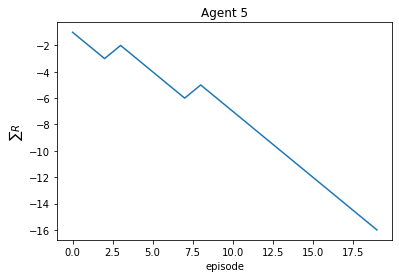

In [604]:
cum_reward = np.cumsum(Agent5.cumulative_reward)
plot_rewards(cum_reward, method = "Agent 5")

### Testing Agent 5

In [593]:
# Retrieve its policy, turn it into a playing strategy for `env.play()`

myw = Agent5.w

def trained_policy(obs): # now defined according to the initial agent policy
    board_id = (tuple(obs.board), obs.mark,)
    # Find estimate for q for each valid action
    board = board_id[0]
    valid_moves = [col for col in range(5) if board[col] == 0]
        
    best_move = np.random.choice(valid_moves) # initialize randomly
        
    q_estimate = [0,0,0,0,0] # initialize
    for i in range(5):
        if i in valid_moves:
            q_estimate[i] = q_hat(env, board_id, i, myw)[0]
        else: 
            q_estimate[i] = -100000 # make it a tiny number otherwise, so invalid moves won't be picked
        
    global test
    test = q_estimate
    action = int(np.argmax(q_estimate))
    return action

#env.play([None, trained_policy])

In [594]:
Agent5.w

array([-0.25562654, -0.82583998,  0.43499817])

#### vs. Random

In [595]:
import random
random.seed(345)
Agent5_vs_random = sim_games(trained_policy, 'random', 1000)
Agent5_vs_random

  0%|          | 0/100 [00:00<?, ?it/s]

(70, 0.7)

#### vs. Negamax

In [596]:
import random
random.seed(345)
Agent4_vs_negamax = sim_games(trained_policy, 'negamax', 1000)
Agent4_vs_negamax

  0%|          | 0/100 [00:00<?, ?it/s]

(7, 0.07)

#### vs. me

In [ ]:
env.play([None, trained_policy])

In [ ]:
env.play([trained_policy, None])